In [1]:
# ============================================================
# 1. ENVIRONMENT SETUP
# ============================================================


import sys
import os

class DevNull:
    def write(self, msg):
        pass
    def flush(self):
        pass

sys.stderr = DevNull()

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.stats import ttest_rel, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
from scipy.stats import ttest_rel

2025-12-26 11:40:35.556787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766749235.716804      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766749235.765186      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load dataset
df = pd.read_csv("/kaggle/input/financial-headlines-augmented/news_augmented.csv")
texts = df["headline"].tolist()
labels = df["sentiment"].map({"negative":0, "neutral":1, "positive":2}).values


In [3]:
df.shape

(7879, 2)

In [4]:
# ============================================================
# 2. LOAD CV RESULTS FROM PICKLE + EXTRACT METRICS
# ============================================================

import pickle

bert_raw       = pickle.load(open("/kaggle/input/bert-zeeshan/bert_5fold_cv_results_cached.pkl", "rb"))
distil_raw     = pickle.load(open("/kaggle/input/distilbert-zeeshan/distilbert_5fold_cv_results_cached.pkl", "rb"))
albert_raw     = pickle.load(open("/kaggle/input/zeeshan-albert/albert_5fold_cv_results_cached.pkl", "rb"))
roberta_raw    = pickle.load(open("/kaggle/input/roberta-zeeshan/roberta_5fold_cv_results_cached.pkl", "rb"))
finbert_raw    = pickle.load(open("/kaggle/input/zeeshan-finbert/finbert_5fold_cv_results_cached.pkl", "rb"))

def extract_metrics(folds):
    accuracy  = [f["eval_accuracy"]  for f in folds]
    precision = [f["eval_precision"] for f in folds]
    recall    = [f["eval_recall"]    for f in folds]
    f1        = [f["eval_f1"]        for f in folds]

    return {
        "accuracy_mean":  np.mean(accuracy),
        "precision_mean": np.mean(precision),
        "recall_mean":    np.mean(recall),
        "f1_mean":        np.mean(f1),

        "accuracy_all": accuracy,
        "precision_all": precision,
        "recall_all": recall,
        "f1_all": f1
    }

bert       = extract_metrics(bert_raw)
distilbert = extract_metrics(distil_raw)
albert     = extract_metrics(albert_raw)
roberta    = extract_metrics(roberta_raw)
finbert    = extract_metrics(finbert_raw)

In [5]:
# ============================================================
# 3. UNIFIED MODEL REGISTRY (SINGLE SOURCE OF TRUTH)
# ============================================================

model_registry = {
    "BERT": {
        "results": bert,
        "path": "/kaggle/input/bert-zeeshan/news_headline_sentiment/checkpoint-282",
        "color": "#ff7f0e"
    },
    "DistilBERT": {
        "results": distilbert,
        "path": "/kaggle/input/distilbert-zeeshan/news_headline_sentiment/checkpoint-376",
        "color": "#2ca02c"
    },
    "ALBERT": {
        "results": albert,
        "path": "/kaggle/input/zeeshan-albert/news_headline_sentiment/checkpoint-376",
        "color": "#9467bd"
    },
    "RoBERTa": {
        "results": roberta,
        "path": "/kaggle/input/roberta-zeeshan/news_headline_sentiment/checkpoint-235",
        "color": "#1f77b4"
    },
    "FinBERT": {
        "results": finbert,
        "path": "/kaggle/input/zeeshan-finbert/news_headline_sentiment/checkpoint-376",
        "color": "#d62728"
    }
}


In [6]:
# ============================================================
# 4. BUILD RESULTS DATAFRAME
# ============================================================

results_df = pd.DataFrame({
    model: {
        "Accuracy": info["results"]["accuracy_mean"],
        "Precision": info["results"]["precision_mean"],
        "Recall": info["results"]["recall_mean"],
        "F1": info["results"]["f1_mean"]
    }
    for model, info in model_registry.items()
}).T.round(4)

display(results_df)

,Accuracy,Precision,Recall,F1
BERT,0.8841,0.8840,0.8841,0.8834
DistilBERT,0.8797,0.8806,0.8797,0.8791
ALBERT,0.8808,0.8820,0.8808,0.8806
RoBERTa,0.8934,0.8935,0.8934,0.8927
FinBERT,0.9025,0.9030,0.9025,0.9021


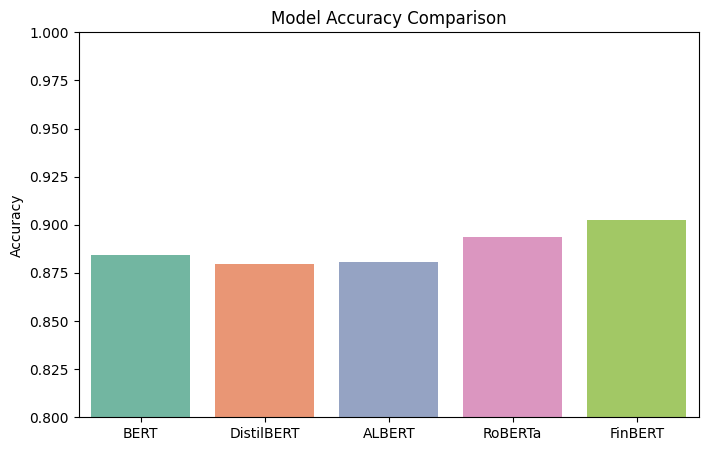

In [7]:
# ============================================================
# 5. VISUALIZATIONS (BAR, RADAR, BOXPLOT, HEATMAP, SCATTER)
# ============================================================

# Accuracy barplot
plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y=results_df["Accuracy"], palette="Set2")
plt.title("Model Accuracy Comparison")
plt.ylim(0.80, 1.00)
plt.show()



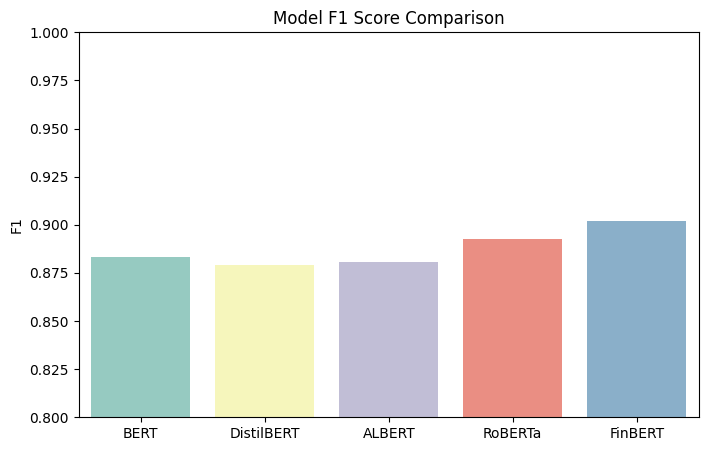

In [8]:
# F1 score barplot
plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y=results_df["F1"], palette="Set3")
plt.title("Model F1 Score Comparison")
plt.ylim(0.80, 1.00)
plt.show()

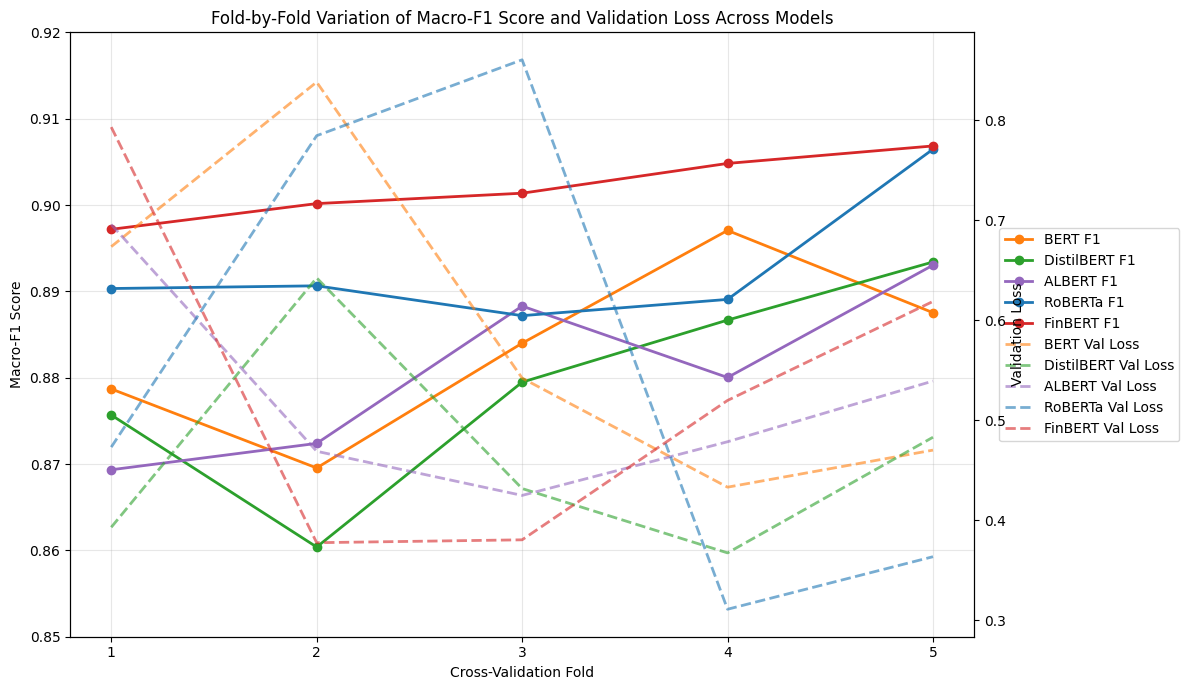

In [9]:
# ============================================================
# Fold-by-Fold Variation of Macro-F1 and Validation Loss
# (All Models in One Plot)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

models_cv = {
    "BERT": bert_raw,
    "DistilBERT": distil_raw,
    "ALBERT": albert_raw,
    "RoBERTa": roberta_raw,
    "FinBERT": finbert_raw
}

colors = {
    "BERT": "#ff7f0e",
    "DistilBERT": "#2ca02c",
    "ALBERT": "#9467bd",
    "RoBERTa": "#1f77b4",
    "FinBERT": "#d62728"
}

folds = np.arange(1, 6)

fig, ax1 = plt.subplots(figsize=(12, 7))

#  Plot Macro-F1 (Left Axis)
for model, results in models_cv.items():
    f1_scores = [r["eval_f1"] for r in results]
    ax1.plot(
        folds,
        f1_scores,
        marker="o",
        linewidth=2,
        color=colors[model],
        label=f"{model} F1"
    )

ax1.set_xlabel("Cross-Validation Fold")
ax1.set_ylabel("Macro-F1 Score")
ax1.set_xticks(folds)
ax1.set_ylim(0.85, 0.92)
ax1.grid(alpha=0.3)

#  Plot Validation Loss (Right Axis)
ax2 = ax1.twinx()

for model, results in models_cv.items():
    val_losses = [r["eval_loss"] for r in results]
    ax2.plot(
        folds,
        val_losses,
        linestyle="--",
        linewidth=2,
        color=colors[model],
        alpha=0.6,
        label=f"{model} Val Loss"
    )

ax2.set_ylabel("Validation Loss")

#  Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True
)

plt.title("Fold-by-Fold Variation of Macro-F1 Score and Validation Loss Across Models")
plt.tight_layout()
plt.show()


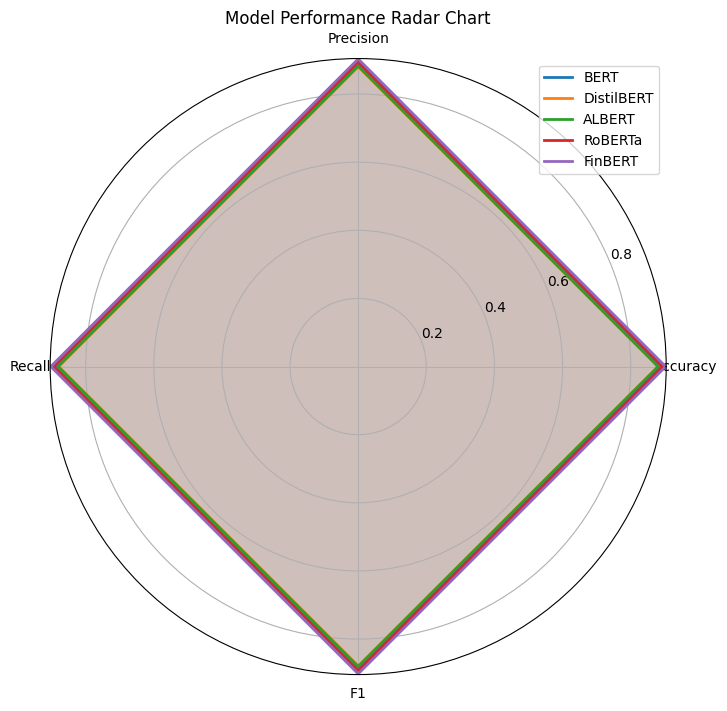

In [10]:
# Radar chart
from math import pi
metrics = ["Accuracy", "Precision", "Recall", "F1"]
N = len(metrics)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

for model in results_df.index:
    values = results_df.loc[model].tolist() + [results_df.loc[model].tolist()[0]]
    ax.plot(angles, values, linewidth=2, label=model)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
plt.title("Model Performance Radar Chart")
plt.legend(loc="upper right")
plt.show()


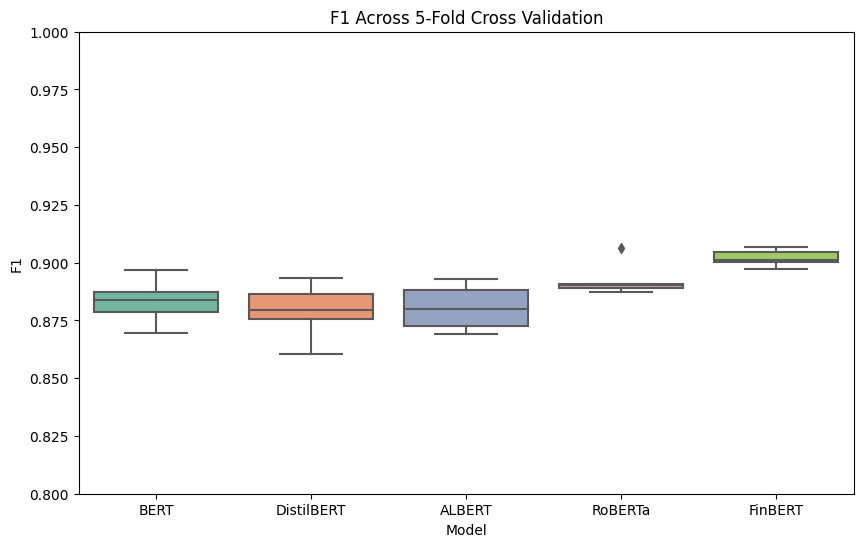

In [11]:
# Boxplot across 5-fold CV
cv_df = pd.DataFrame({
    "Model": sum([[m]*5 for m in model_registry.keys()], []),
    "F1": sum([model_registry[m]["results"]["f1_all"] for m in model_registry], [])
})

plt.figure(figsize=(10,6))
sns.boxplot(x="Model", y="F1", data=cv_df, palette="Set2")
plt.title("F1 Across 5-Fold Cross Validation")
plt.ylim(0.80, 1.00)
plt.show()

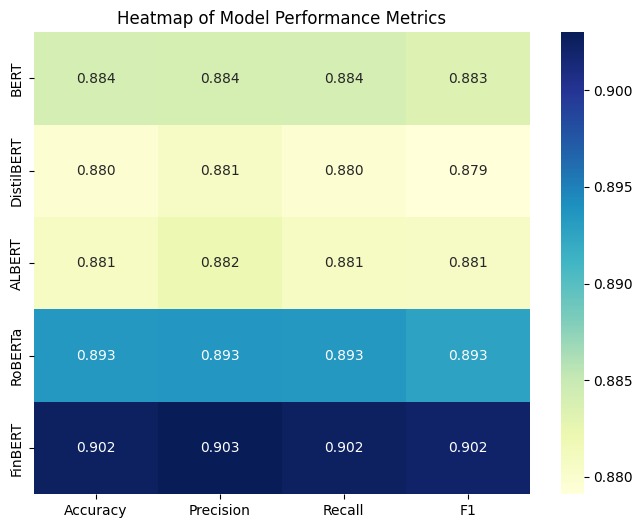

In [12]:
# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(results_df, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Heatmap of Model Performance Metrics")
plt.show()

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

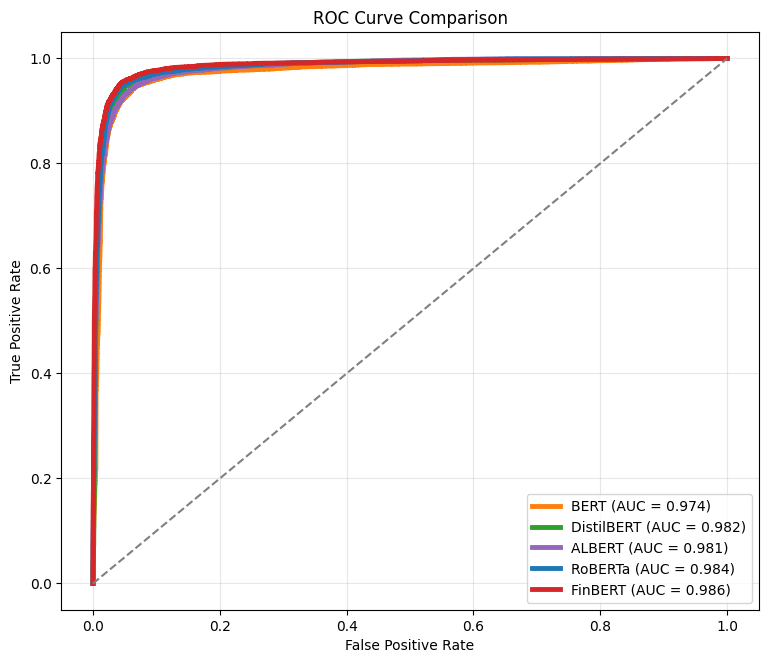

In [13]:
# ============================================================
# 6. ROC CURVE (MICRO-AVERAGED)
# ============================================================

def get_micro_roc(model_path, name, color):
    tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    probs = []
    batch_size = 64
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            inputs = tokenizer(batch, padding=True, truncation=True,
                               max_length=128, return_tensors="pt").to(device)
            outputs = model(**inputs)
            prob = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
            probs.append(prob)

    y_score = np.vstack(probs)
    y_bin = label_binarize(labels, classes=[0,1,2])

    fpr, tpr, _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

plt.figure(figsize=(9,7.5))

for model, info in model_registry.items():
    fpr, tpr, roc_auc = get_micro_roc(info["path"], model, info["color"])
    plt.plot(fpr, tpr, lw=3.5, color=info["color"],
             label=f"{model} (AUC = {roc_auc:.3f})")

plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [14]:
# ============================================================
# 7. STATISTICAL TESTS (T-TEST, ANOVA, TUKEY)
# ============================================================

# Collect fold-level F1 scores for each model
f1_scores = {
    "BERT": bert["f1_all"],
    "DistilBERT": distilbert["f1_all"],
    "ALBERT": albert["f1_all"],
    "RoBERTa": roberta["f1_all"],
    "FinBERT": finbert["f1_all"]
}
# Perform paired t-tests for all model pairs
ttest_rows = []

for (model_a, scores_a), (model_b, scores_b) in combinations(f1_scores.items(), 2):
    t_stat, p_value = ttest_rel(scores_a, scores_b)
    mean_diff = np.mean(scores_a) - np.mean(scores_b)

    ttest_rows.append({
        "Model A": model_a,
        "Model B": model_b,
        "Mean F1 (A)": np.mean(scores_a),
        "Mean F1 (B)": np.mean(scores_b),
        "Mean Difference (A − B)": mean_diff,
        "t-statistic": t_stat,
        "p-value": p_value,
        "Significant (α = 0.05)": "Yes" if p_value < 0.05 else "No"
    })

# Convert to DataFrame
ttest_df = pd.DataFrame(ttest_rows).round(5)

display(ttest_df)


,Model A,Model B,Mean F1 (A),Mean F1 (B),Mean Difference (A − B),t-statistic,p-value,Significant (α = 0.05)
0,BERT,DistilBERT,0.88337,0.87912,0.00424,1.47298,0.21475,No
1,BERT,ALBERT,0.88337,0.88062,0.00275,0.61731,0.57043,No
2,BERT,RoBERTa,0.88337,0.89274,-0.00937,-1.74999,0.15502,No
3,BERT,FinBERT,0.88337,0.90208,-0.01871,-5.15081,0.00674,Yes
4,DistilBERT,ALBERT,0.87912,0.88062,-0.00149,-0.38812,0.71770,No
5,DistilBERT,RoBERTa,0.87912,0.89274,-0.01361,-2.90523,0.04389,Yes
6,DistilBERT,FinBERT,0.87912,0.90208,-0.02295,-5.13249,0.00683,Yes
7,ALBERT,RoBERTa,0.88062,0.89274,-0.01212,-3.11687,0.03563,Yes
8,ALBERT,FinBERT,0.88062,0.90208,-0.02146,-6.46091,0.00296,Yes
9,RoBERTa,FinBERT,0.89274,0.90208,-0.00934,-3.39749,0.02734,Yes


In [15]:
# Cohen’s d effect size
finbert_scores = model_registry["FinBERT"]["results"]["f1_all"]
def cohens_d_paired(x, y):
    diff = np.array(x) - np.array(y)
    return diff.mean() / diff.std(ddof=1)

for model, info in model_registry.items():
    if model != "FinBERT":
        d = cohens_d_paired(finbert_scores, info["results"]["f1_all"])
        print(f"FinBERT vs {model}: Cohen's d = {d:.3f}")

FinBERT vs BERT: Cohen's d = 2.304
FinBERT vs DistilBERT: Cohen's d = 2.295
FinBERT vs ALBERT: Cohen's d = 2.889
FinBERT vs RoBERTa: Cohen's d = 1.519


In [16]:
# ANOVA
anova_stat, anova_p = f_oneway(
    *[info["results"]["f1_all"] for info in model_registry.values()]
)
print("\nANOVA:", anova_stat, anova_p)



ANOVA: 5.344905556673104 0.0042903011830102995


In [17]:
# Tukey HSD
tukey_df = pd.DataFrame({
    "F1": sum([info["results"]["f1_all"] for info in model_registry.values()], []),
    "Model": sum([[m]*5 for m in model_registry.keys()], [])
})
tukey_results = pairwise_tukeyhsd(tukey_df["F1"], tukey_df["Model"])
print(tukey_results)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
    ALBERT       BERT   0.0027 0.9897  -0.015 0.0205  False
    ALBERT DistilBERT  -0.0015  0.999 -0.0192 0.0162  False
    ALBERT    FinBERT   0.0215  0.013  0.0037 0.0392   True
    ALBERT    RoBERTa   0.0121 0.2804 -0.0056 0.0298  False
      BERT DistilBERT  -0.0042 0.9502  -0.022 0.0135  False
      BERT    FinBERT   0.0187 0.0352   0.001 0.0364   True
      BERT    RoBERTa   0.0094 0.5241 -0.0083 0.0271  False
DistilBERT    FinBERT    0.023 0.0074  0.0052 0.0407   True
DistilBERT    RoBERTa   0.0136  0.186 -0.0041 0.0313  False
   FinBERT    RoBERTa  -0.0093 0.5275  -0.027 0.0084  False
-----------------------------------------------------------


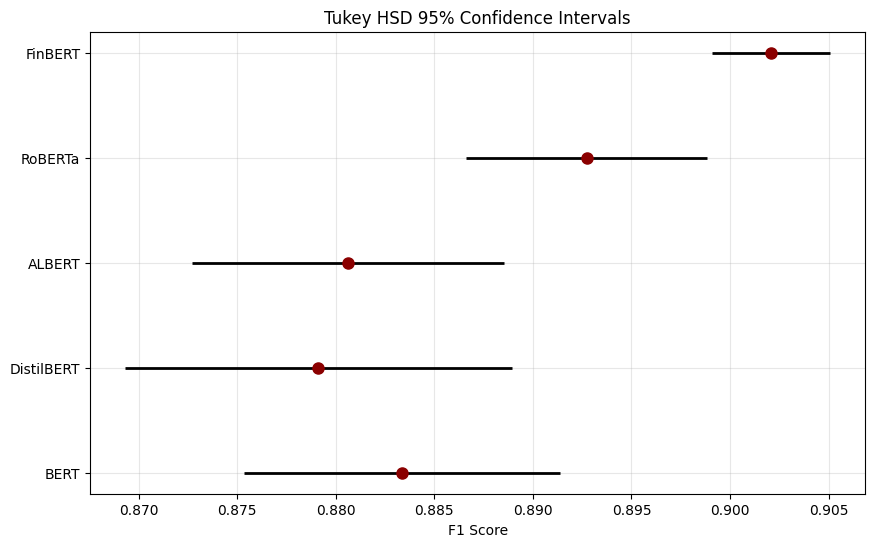

In [18]:
# ============================================================
# 8. Tukey CI Plot (Publication-Quality)
# ============================================================

model_order = list(model_registry.keys())

model_means = {m: np.mean(model_registry[m]["results"]["f1_all"]) for m in model_order}

ci_bounds = {}
for m in model_order:
    vals = model_registry[m]["results"]["f1_all"]
    mean = np.mean(vals)
    sem = np.std(vals) / np.sqrt(len(vals))
    ci_bounds[m] = (mean - 1.96*sem, mean + 1.96*sem)

means = [model_means[m] for m in model_order]
lower_ci = [ci_bounds[m][0] for m in model_order]
upper_ci = [ci_bounds[m][1] for m in model_order]

plt.figure(figsize=(10,6))
y = np.arange(len(model_order))

plt.hlines(y, lower_ci, upper_ci, colors="black", linewidth=2)
plt.plot(means, y, "o", color="darkred", markersize=8)
plt.yticks(y, model_order)
plt.xlabel("F1 Score")
plt.title("Tukey HSD 95% Confidence Intervals")
plt.grid(alpha=0.3)
plt.show()